In [2]:
# from zipfile import ZipFile
# with ZipFile('/content/gdrive/MyDrive/Dataset.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# %pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.7 MB/s 


In [4]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
size_x,size_y,classes=128,128,2
num_images = 500

In [5]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [6]:
image_names = glob.glob("D:\\university\\Dataset\\Dataset\\Brain scans\\Tumor\\TRAIN\\*.jpg")
image_names.sort()
images = [cv2.resize(cv2.imread(image, 1), (128, 128)) for image in image_names] #SM backbones use 3 channel images, so let us read images in color.
image_dataset = np.array(images)

In [7]:
len(image_dataset)

500

In [8]:
mask_names = glob.glob("D:\\university\\Dataset\\Dataset\\Brain scans\\Tumor\\TRAIN_masks\\*.png")
mask_names.sort()
masks=[]
for mask in mask_names:
  ret,thresh =cv2.threshold(cv2.resize(cv2.imread(mask, 0),(128,128)),55,255,0)
  masks.append(thresh)
mask_dataset = np.array(masks)
print(np.unique(np.array(masks)))

[  0 255]


In [9]:
len(mask_dataset)

500

In [10]:
print("Total images in the original dataset are: ", len(image_names))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  500
Image data shape is:  (500, 128, 128, 3)
Mask data shape is:  (500, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


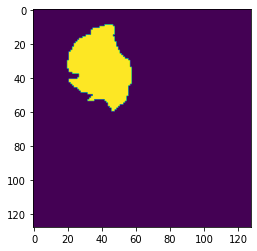

In [11]:
plt.imshow(mask_dataset[0])

In [12]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)
     

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [13]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(500, 128, 128, 1)


In [14]:
image_dataset = image_dataset /255.

In [15]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [16]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=2)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))

test_masks_cat = to_categorical(y_test, num_classes=2)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))


In [17]:

print(y_train_cat.shape)

print(test_masks_cat.shape)

(400, 128, 128, 2)
(100, 128, 128, 2)


In [18]:
#Reused parameters in all models
import tensorflow
n_classes=2
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [19]:
###Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)


print(model.summary())

85521592/85521592 [==============================] - 6s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [20]:
import time 
start=time.time()
history=model.fit(X_train_processed, 
          y_train_cat,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))
end =time.time()
execution=end-start


Epoch 1/20
50/50 [==============================] - 19s 93ms/step - loss: 0.5056 - iou_score: 0.5051 - f1-score: 0.5821 - val_loss: 0.5961 - val_iou_score: 0.4729 - val_f1-score: 0.4861
Epoch 2/20
50/50 [==============================] - 3s 66ms/step - loss: 0.3998 - iou_score: 0.6597 - f1-score: 0.7570 - val_loss: 0.5458 - val_iou_score: 0.4730 - val_f1-score: 0.4861
Epoch 3/20
50/50 [==============================] - 3s 66ms/step - loss: 0.2615 - iou_score: 0.7707 - f1-score: 0.8540 - val_loss: 0.5132 - val_iou_score: 0.4730 - val_f1-score: 0.4861
Epoch 4/20
50/50 [==============================] - 3s 68ms/step - loss: 0.1663 - iou_score: 0.8350 - f1-score: 0.9024 - val_loss: 0.5067 - val_iou_score: 0.4730 - val_f1-score: 0.4861
Epoch 5/20
50/50 [==============================] - 3s 67ms/step - loss: 0.1239 - iou_score: 0.8620 - f1-score: 0.9206 - val_loss: 0.5347 - val_iou_score: 0.4730 - val_f1-score: 0.4861
Epoch 6/20
50/50 [==============================] - 3s 66ms/step - loss: 0

In [22]:
print("Time ",round(execution,1)," seconds")

Time  84.1  seconds


In [ ]:
# model.load_weights('C:\\Users\\Sherif Essam\\OneDrive\\Desktop\\segm\\weights.h5')

In [23]:
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

4/4 [==============================] - 2s 28ms/step


In [24]:
print(X_test_processed.shape)

(100, 128, 128, 3)


In [25]:
print(y_test.shape,y_pred_argmax.shape)

(100, 128, 128, 1) (100, 128, 128)


In [26]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
     

Mean IoU = 0.864014


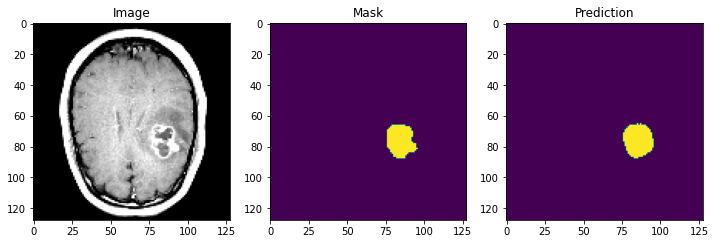

In [27]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

In [28]:
image_names2 = glob.glob("D:\\university\\Dataset\\Dataset\\Brain scans\\Tumor\\TEST\\*.jpg")
image_names2.sort()
images = [cv2.resize(cv2.imread(image, 1), (128, 128)) for image in image_names2] #SM backbones use 3 channel images, so let us read images in color.
image_dataset2 = np.array(images)

In [29]:
mask_names2 = glob.glob("D:\\university\\Dataset\\Dataset\\Brain scans\\Tumor\\TEST\\*.jpg")
mask_names2.sort()
masks=[]
for mask in mask_names2:
  ret,thresh =cv2.threshold(cv2.resize(cv2.imread(mask, 0),(128,128)),55,255,0)
  masks.append(thresh)
mask_dataset2 = np.array(masks)
print(np.unique(np.array(masks)))

[  0 255]


In [30]:
print(len(image_dataset2))
print(len(mask_dataset2))

100
100


In [31]:
labelencoder = LabelEncoder()
n, h, w = mask_dataset2.shape  
mask_dataset_reshaped = mask_dataset2.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

array([0, 1])

In [32]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(100, 128, 128, 1)


In [33]:
image_dataset2 = image_dataset2 /255.

In [34]:
X_processed = preprocess_input(image_dataset2)

In [35]:
X_processed.shape


(100, 128, 128, 3)

In [36]:
import time 
start=time.time()
y_pred2=model.predict(X_processed)
y_pred_argmax2=np.argmax(y_pred2, axis=3)
end =time.time()
execution=end-start
print("Time ",round(execution,1)," seconds")

4/4 [==============================] - 0s 52ms/step
Time  0.4  seconds


In [37]:
y_pred_argmax2.shape

(100, 128, 128)

In [38]:
print(mask_dataset_encoded.shape,y_pred_argmax2.shape)


(100, 128, 128, 1) (100, 128, 128)


In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(mask_dataset_encoded[:,:,:,0], y_pred_argmax2)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83298266


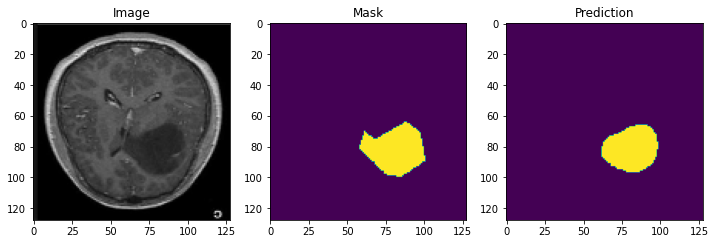

In [40]:

img_number = random.randint(0, len(X_processed)-1)
img = X_processed[img_number]
mask = mask_dataset_encoded[img_number]
prediction = y_pred_argmax2[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()

30 X 36 pixels


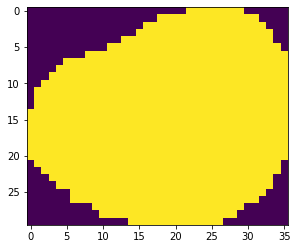

In [41]:
x_min=999
x_max=0
y_min=999
y_max=0
for i in range(len(prediction)):
  for j in range(len(prediction[0])):
    if prediction[i][j]==1:
      if i>y_max:
        y_max=i
      if i<y_min:
        y_min=i
      if j>x_max:
        x_max=j
      if j<x_min:
        x_min=j
# print(x_min,x_max,y_min,y_max)
print(y_max-y_min,'X',x_max-x_min,'pixels')
plt.imshow(prediction[y_min:y_max,x_min:x_max])

In [ ]:
# model.save_weights('weights.h5')